In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_confusion_matrix
from jcopml.feature_importance import mean_score_decrease

from luwiji.text_proc import illustration

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

## Import  Datasets

In [2]:
df = pd.read_csv("datasets/spam_or_not_spam.csv")
df = df.dropna()
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


## Datasests Splitting

In [3]:
X = df["email"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2399,), (600,), (2399,), (600,))

## training

In [8]:
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV

from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real

In [9]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words='english')),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

# membuat parameter untuk tuning
parameter_tune = {
    'algo__max_depth': Integer(low=4, high=10),
    'algo__learning_rate': Real(low=-3, high=0, prior='log-uniform'),
    'algo__n_estimators': Integer(low=50, high=100),
    'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
    'algo__gamma': Integer(low=1, high=10),
    'algo__colsample_bytree': Real(low=0.4, high=0.8, prior='uniform'),
    'algo__reg_alpha': Real(low=-2, high=2, prior='log-uniform'),
    'algo__reg_lambda': Real(low=0, high=3, prior='log-uniform')
}

model = RandomizedSearchCV(pipeline, parameter_tune, cv=4, n_iter=20, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.5min finished


{'algo__colsample_bytree': 0.5531707499015159, 'algo__gamma': 3, 'algo__learning_rate': 0.19158219548093175, 'algo__max_depth': 5, 'algo__n_estimators': 63, 'algo__reg_alpha': 0.9444574254983565, 'algo__reg_lambda': 36.9997243146381, 'algo__subsample': 0.5137705091792748}
0.9783243017924135 0.9612346967167502 0.9633333333333334


## Scoring

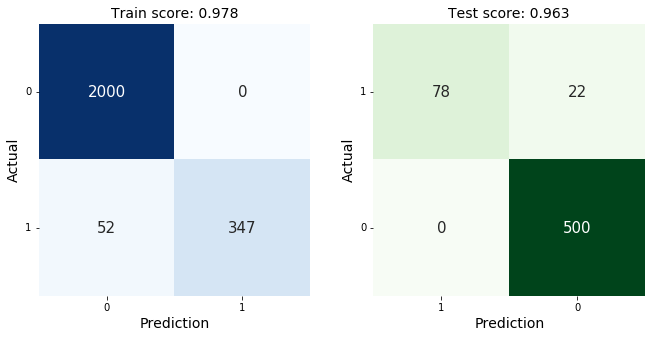

In [10]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)